# Fixing the Vanishing Gradient Problem with Rectified Linear Unit (ReLU)

## Example Problem: Two Circles Binary Classification

To help investigate the problem, we study the classic binary classification problem. We use the [`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) function provided by `scikit-learn` to create a binary classification problem with given number of samples and statistical noise.

In [1]:
# import required libraries
from sklearn.datasets import make_circles
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from skorch import NeuralNetBinaryClassifier

We create the dataset with $X$ denoting the input variables (coordinates in the Cartesian plane) and the label vector $y$ denoting class values in $\{0, 1\}$. The points are arranged in two concentric circles for the two classes, with parameters:
- `n_samples`: number of points in the dataset, where half of the data points will be drawn for each circle
- `noise`: the standard deviation of the noise, `noise = 0.0` indicates no noise or points drawn exactly from the circles
- `random_state`: seed for the pseudorandom number generator for reproducibility

The statistical noise causes the overlap of the points in the two classes.

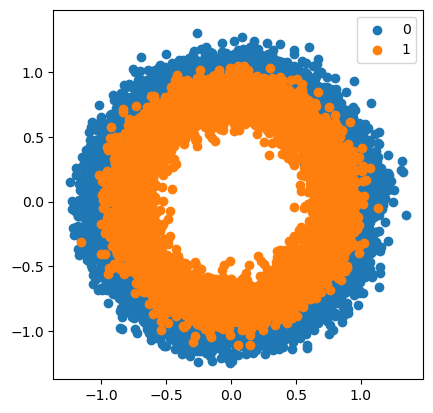

In [2]:
# generate circles
X, y = make_circles(n_samples=10000, noise=0.1, random_state=1)

for i in range(len(np.unique(y))):
    sample_indices = np.where(y == i)
    plt.scatter(X[sample_indices, 0], X[sample_indices, 1], label=str(i))
plt.legend()
plt.axis('square');

## Multi-Layer Perceptron

In [3]:
# select device based on hardware
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# scale the data into [-1., 1.]
scaler = MinMaxScaler(feature_range=(-1., 1.))
X = scaler.fit_transform(X)

In [5]:
X, y = X.astype(np.float32), y.astype(np.float32)

In [6]:
# train/test split
num_train = int(0.8 * len(y))
trainX, testX = X[:num_train, :], X[num_train:, :]
trainy, testy = y[:num_train], y[num_train:]

In [7]:
# weight initializer function
def init_weights(module):
    if isinstance(module, torch.nn.Linear):
        torch.nn.init.uniform_(module.weight, 0., 1.)

In [8]:
# some common hyperparameters
max_epochs = 500
lr = 0.1
verbose = 1

In [9]:
class MultiLayerPerceptronTanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=5, out_features=1),
        )

    def forward(self, x):
        init_weights(self.mlp)
        return self.mlp(x)

In [10]:
net_tanh = NeuralNetBinaryClassifier(
    MultiLayerPerceptronTanh,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [11]:
history_tanh = net_tanh.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6970       0.5169        0.6937  0.8693
      2        0.6956       0.5156        0.6933  0.0877
      3        0.6949       0.5181        0.6930  0.0999
      4        0.6945       0.5188        0.6929  0.1031
      5        0.6942       0.5188        0.6928  0.0916
      6        0.6940       0.5181        0.6928  0.0981
      7        0.6938       0.5200        0.6928  0.0864
      8        0.6936       0.5256        0.6928  0.0985
      9        0.6935       0.5300        0.6927  0.0899
     10        0.6934       0.5375        0.6927  0.1013
     11        0.6933       0.5475        0.6927  0.0994
     12        0.6932       0.5544        0.6927  0.1003
     13        0.6931       0.5556        0.6927  0.0878
     14        0.6930       0.5663        0.6927  0.0819
     15        0.6929       0.5713        0.6927  0.0790
     16        0.6928       0.5

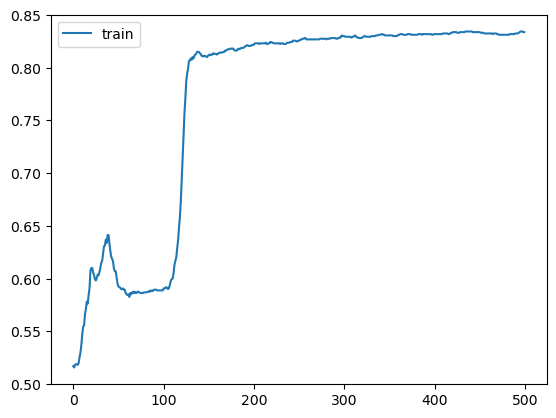

In [12]:
plt.plot(history_tanh.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [13]:
# evaluate the model
predictions_tanh = net_tanh.predict(testX)
test_acc_tanh = np.sum(predictions_tanh == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_tanh}')

Average test accuracy: 0.8255


In [14]:
del history_tanh

In [15]:
class MultiLayerPerceptronReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.mlp)
        return self.mlp(x)

In [16]:
net_relu = NeuralNetBinaryClassifier(
    MultiLayerPerceptronReLU,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [17]:
history_relu = net_relu.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6964       0.4994        0.6932  0.0949
      2        0.6931       0.5487        0.6921  0.1005
      3        0.6926       0.5350        0.6917  0.0972
      4        0.6923       0.5350        0.6913  0.0830
      5        0.6919       0.5375        0.6908  0.0838
      6        0.6915       0.5537        0.6904  0.0823
      7        0.6911       0.5781        0.6898  0.0875
      8        0.6906       0.5950        0.6893  0.0841
      9        0.6899       0.6006        0.6887  0.0863
     10        0.6892       0.5863        0.6881  0.0849
     11        0.6885       0.5744        0.6874  0.0819
     12        0.6877       0.5731        0.6868  0.0851
     13        0.6869       0.5719        0.6862  0.0869
     14        0.6861       0.5744        0.6855  0.0846
     15        0.6853       0.5687        0.6849  0.0830
     16        0.6845       0.5

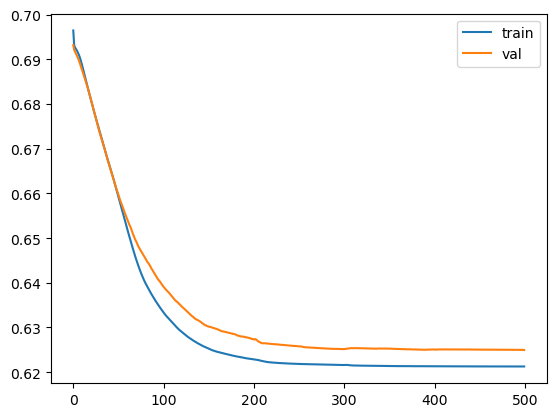

In [18]:
plt.plot(history_relu.history[:, 'train_loss'], label='train')
plt.plot(history_relu.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

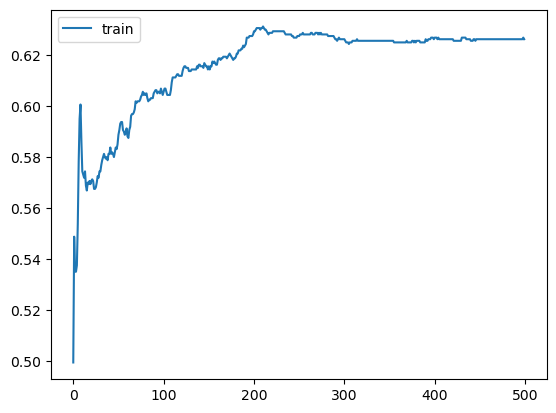

In [19]:
plt.plot(history_relu.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [20]:
# evaluate the model
predictions_relu = net_relu.predict(testX)
test_acc_relu = np.sum(predictions_relu == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_relu}')

Average test accuracy: 0.6365


## Deeper Models

In [21]:
layer = torch.nn.Linear(in_features=5, out_features=5)

In [22]:
# defaults to Kaiming He initialization
class DeepNeuralNetworkTanh(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deep =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            layer,
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.deep)
        return self.deep(x)

In [23]:
deepnet_tanh = NeuralNetBinaryClassifier(
    DeepNeuralNetworkTanh,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [24]:
history_deeptanh = deepnet_tanh.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7024       0.4981        0.6929  0.1170
      2        0.6933       0.6156        0.6926  0.1140
      3        0.6932       0.5069        0.6925  0.1070
      4        0.6931       0.5131        0.6924  0.1105
      5        0.6930       0.5312        0.6924  0.1074
      6        0.6929       0.5613        0.6923  0.1103
      7        0.6928       0.5725        0.6922  0.1053
      8        0.6927       0.5713        0.6921  0.1097
      9        0.6926       0.5613        0.6920  0.1060
     10        0.6925       0.5544        0.6919  0.1100
     11        0.6924       0.5469        0.6918  0.1119
     12        0.6923       0.5419        0.6917  0.1077
     13        0.6922       0.5406        0.6915  0.1123
     14        0.6920       0.5387        0.6913  0.1033
     15        0.6919       0.5394        0.6912  0.1054
     16        0.6917       0.5

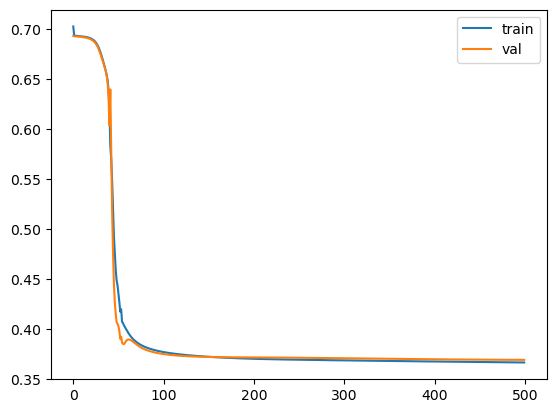

In [25]:
plt.plot(history_deeptanh.history[:, 'train_loss'], label='train')
plt.plot(history_deeptanh.history[:, 'valid_loss'], label='val')
plt.legend()
plt.show()

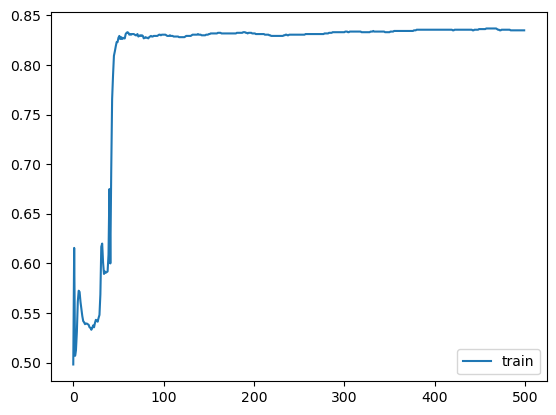

In [26]:
plt.plot(history_deeptanh.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [27]:
# evaluate the model
predictions_deeptanh = deepnet_tanh.predict(testX)
test_acc_deeptanh = np.sum(predictions_deeptanh == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_deeptanh}')

Average test accuracy: 0.834


In [28]:
del history_deeptanh

In [29]:
del deepnet_tanh

In [30]:
# defaults to Kaiming He initialization
class DeepNeuralNetworkReLU(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.deep =  torch.nn.Sequential(
            torch.nn.Linear(in_features=2, out_features=5),
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            layer,
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=5, out_features=1)
        )
    def forward(self, x):
        init_weights(self.deep)
        return self.deep(x)

In [31]:
deepnet_relu = NeuralNetBinaryClassifier(
    DeepNeuralNetworkReLU,
    max_epochs=max_epochs,
    lr=lr,
    device=device,
    verbose=verbose
)

In [32]:
history_deeprelu = deepnet_relu.fit(trainX, trainy)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6842       0.6312        0.6736  0.1205
      2        0.6712       0.6550        0.6555  0.1122
      3        0.6530       0.6806        0.6295  0.1123
      4        0.6268       0.5887        0.6339  0.1083
      5        0.6116       0.7075        0.5761  0.1067
      6        0.6024       0.7037        0.5672  0.1083
      7        0.6012       0.6781        0.5857  0.1064
      8        0.5771       0.7425        0.5221  0.1086
      9        0.5797       0.7275        0.5422  0.1181
     10        0.5538       0.7588        0.5036  0.1202
     11        0.5544       0.7788        0.4924  0.1003
     12        0.5464       0.7538        0.5067  0.1030
     13        0.5390       0.7481        0.5093  0.1069
     14        0.5354       0.7269        0.5300  0.1002
     15        0.5162       0.7581        0.4988  0.1078
     16        0.5117       0.8

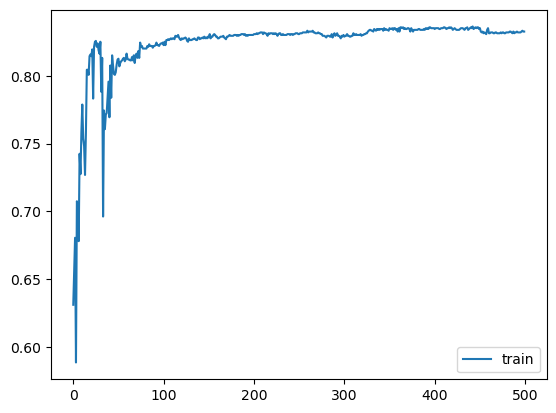

In [33]:
plt.plot(history_deeprelu.history[:, 'valid_acc'], label='train')
plt.legend()
plt.show()

In [34]:
# evaluate the model
predictions_deeprelu = deepnet_relu.predict(testX)
test_acc_deeprelu = np.sum(predictions_deeprelu == testy.astype(int)) / len(testy)
print(f'Average test accuracy: {test_acc_deeprelu}')

Average test accuracy: 0.8315


In [35]:
del history_deeprelu

In [36]:
del deepnet_relu